## Project: Toxic Comment Filter

Costruire un modello in grado di filtrare i commenti degli utenti in base al grado di dannosità del linguaggio:
1. Preprocessare il testo eliminando l'insieme di token che non danno contributo significativo a livello semantico
2. Trasformare il corpus testuale in sequenze
3. Costruire un modello di Deep Learning comprendente dei layer ricorrenti per un task di classificazione multilabel
4. In prediction time, il modello deve ritornare un vettore contenente un 1 o uno 0 in corrispondenza di ogni label presente nel dataset (toxic,	severe_toxic,	obscene,	threat,	insult,	identity_hate). In questo modo, un commento non dannoso sarà classificato da un vettore di soli 0 [0,0,0,0,0,0]. Al contrario, un commento pericoloso presenterà almeno un 1 tra le 6 labels.

In [1]:
#say no to warnings!
import warnings
warnings.filterwarnings("ignore")
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
from tensorflow.keras.backend import clear_session
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
import pickle
from keras.layers import BatchNormalization, SpatialDropout1D, GRU, Dense, Embedding, Conv1D, GlobalMaxPooling1D
import seaborn as sns
from keras.optimizers import Adam
from keras.initializers import Constant
from sklearn.metrics import multilabel_confusion_matrix


In [3]:
BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")

In [4]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [5]:
len(df)

159571

In [6]:
#quante frasi ho per ogni categoria
conteggio_categorie = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
print(conteggio_categorie) #molto sbilanciato per alcune categorie

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


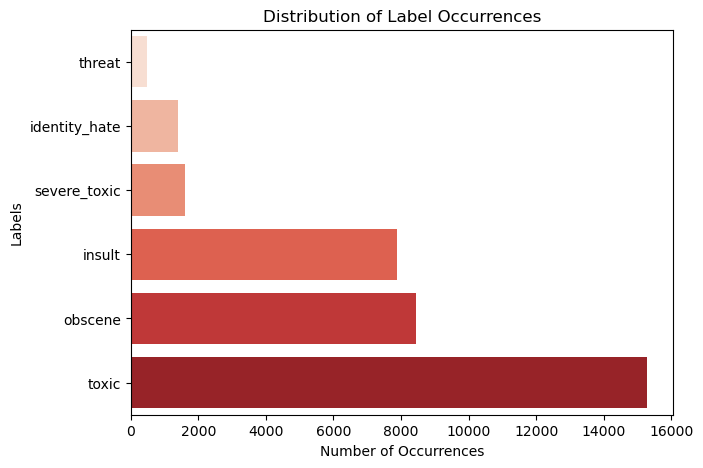

In [7]:
# Distribuzione dei label di interesse
column_labels = df.columns.tolist()[1:-1]
label_counts = df[column_labels].sum().sort_values()

plt.figure(figsize=(7, 5))

# barplot orizzontale
ax = sns.barplot(x=label_counts.values,
				y=label_counts.index, palette='Reds')

plt.xlabel('Number of Occurrences')
plt.ylabel('Labels')
plt.title('Distribution of Label Occurrences')

plt.show()

In [8]:
def plot_label_distribution(df_toxic, df_clean):

    # numero dei commenti puliti e tossici
    num_toxic = len(df_toxic)
    num_clean = len(df_clean)

    # creo un dataframe per la visualizzazione
    plot_data = pd.DataFrame(
        {'Category': ['Toxic', 'Clean'], 'Count': [num_toxic, num_clean]})

    plt.figure(figsize=(7, 5))

    # barplot orizzontale
    colors = ["red", "green"]
    ax = sns.barplot(x='Count', y='Category', data=plot_data, palette=colors)

    plt.xlabel('Number of Comments')
    plt.ylabel('Category')
    plt.title('Distribution of Toxic and Clean Comments')

    plt.show()

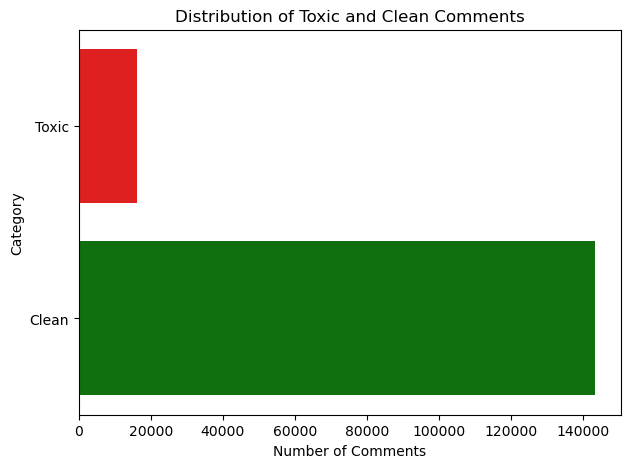

In [9]:
# df_toxic:solo commenti tossici; 
# df_clean:solo commenti sani
injurious_col = 'sum_injurious'
df_toxic = df[df[injurious_col] > 0]
df_clean = df[df[injurious_col] == 0]

plot_label_distribution(df_toxic, df_clean)

In [10]:
print(df_toxic.shape[0])
print(df_clean.shape[0]) #estrememante sbilanciato, come è normale che sia

16225
143346


In [11]:
#undersampling dei commenti non tossici

# Calcolo il numero di righe da eliminare
num_righe_da_eliminare = len(df_clean) - 16225

# Seleziono un campione casuale di righe da eliminare
righe_da_eliminare = df_clean.sample(n=num_righe_da_eliminare, random_state = 1)

# Elimino le righe selezionate
df = df.drop(righe_da_eliminare.index)


In [12]:
df.shape # 16225 clean + 16225 toxic

(32450, 8)

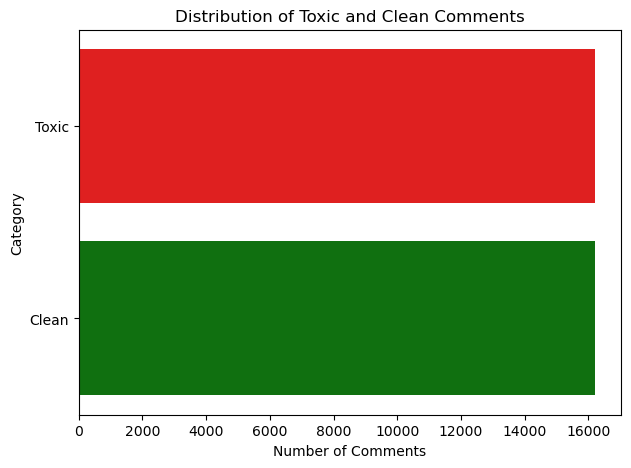

In [13]:
plot_label_distribution(df[df[injurious_col] > 0], df[df[injurious_col] == 0])

# Preprocessing

In [14]:
X = df["comment_text"].values
Y = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values
df_train, df_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=1)

In [15]:
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df_train)

In [16]:
X_train = tokenizer.texts_to_sequences(df_train)
X_test = tokenizer.texts_to_sequences(df_test)

In [17]:
vocabulary_size = len(tokenizer.word_index)+1
maxlen = len(max(X_train, key=len))

In [18]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# modello da zero

In [19]:
clear_session()

# Inizializzazione del modello
gru_model = Sequential()
# Aggiunta del layer di embedding
gru_model.add(Embedding(input_dim=vocabulary_size, output_dim=128, input_length=maxlen))
# Dropout spaziale per ridurre l'overfitting
gru_model.add(SpatialDropout1D(0.2))
# Aggiunta di un GRU layer
gru_model.add(GRU(128))
# 6 categorie per la classificazione multilabel
gru_model.add(Dense(6, activation='sigmoid'))  

In [20]:
gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1400, 128)         7953920   
                                                                 
 spatial_dropout1d (Spatial  (None, 1400, 128)         0         
 Dropout1D)                                                      
                                                                 
 gru (GRU)                   (None, 128)               99072     
                                                                 
 dense (Dense)               (None, 6)                 774       
                                                                 
Total params: 8053766 (30.72 MB)
Trainable params: 8053766 (30.72 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
#compile
gru_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer="adam")

In [22]:
# early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [23]:
# Addestramento del modello
history = gru_model.fit(X_train, Y_train, batch_size=32, validation_split=0.1, epochs=10, callbacks=[early_stopping])

Epoch 1/10
731/731 [==============================] - 1022s 1s/step - loss: 0.2391 - accuracy: 0.9664 - val_loss: 0.1773 - val_accuracy: 0.9584
Epoch 2/10
731/731 [==============================] - 1010s 1s/step - loss: 0.1669 - accuracy: 0.9528 - val_loss: 0.1698 - val_accuracy: 0.9515
Epoch 3/10
731/731 [==============================] - 1011s 1s/step - loss: 0.1458 - accuracy: 0.8709 - val_loss: 0.1714 - val_accuracy: 0.8640
Epoch 4/10
731/731 [==============================] - 1015s 1s/step - loss: 0.1268 - accuracy: 0.7865 - val_loss: 0.1788 - val_accuracy: 0.8082


In [24]:
# salvo i pesi
gru_model.save_weights('GRU_model_weights')

In [22]:
#carico i pesi
#gru_model.load_weights('GRU_model_weights')

## Performance su test set

In [23]:
Y_pred_gru = gru_model.predict(X_test, verbose=0)

# Conversione delle previsioni in etichette binarie
Y_pred_bin_gru = np.where(Y_pred_gru > 0.5, 1, 0)

print(classification_report(Y_test, Y_pred_bin_gru, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

               precision    recall  f1-score   support

        toxic       0.89      0.86      0.88      3049
 severe_toxic       0.59      0.15      0.24       316
      obscene       0.85      0.80      0.83      1723
       threat       0.44      0.26      0.33        87
       insult       0.72      0.78      0.75      1599
identity_hate       0.58      0.35      0.43       286

    micro avg       0.82      0.77      0.79      7060
    macro avg       0.68      0.54      0.58      7060
 weighted avg       0.81      0.77      0.78      7060
  samples avg       0.37      0.37      0.35      7060



## Analisi misclassificazioni

In [24]:
def print_multi_conf_matrix(Y_pred):

    # Conversione delle previsioni in etichette binarie
    Y_pred_bin = np.where(Y_pred > 0.5, 1, 0)
    
    #creo una matrice di confusione per ogni label
    multi_conf_matrix = multilabel_confusion_matrix(Y_test, Y_pred_bin)

    # Nomi delle categorie con apici
    target_names = ['"toxic"', '"severe_toxic"', '"obscene"', '"threat"', '"insult"', '"identity_hate"']

    # Impostazione della dimensione del subplot
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    # Creazione di una heatmap per ogni matrice di confusione
    for i, ax in enumerate(axes.flatten()):
        sns.heatmap(multi_conf_matrix[i], annot=True, fmt='d', cmap='Reds', cbar=False, ax=ax)
        ax.set_title(target_names[i])
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')

    plt.tight_layout()

    plt.show() 

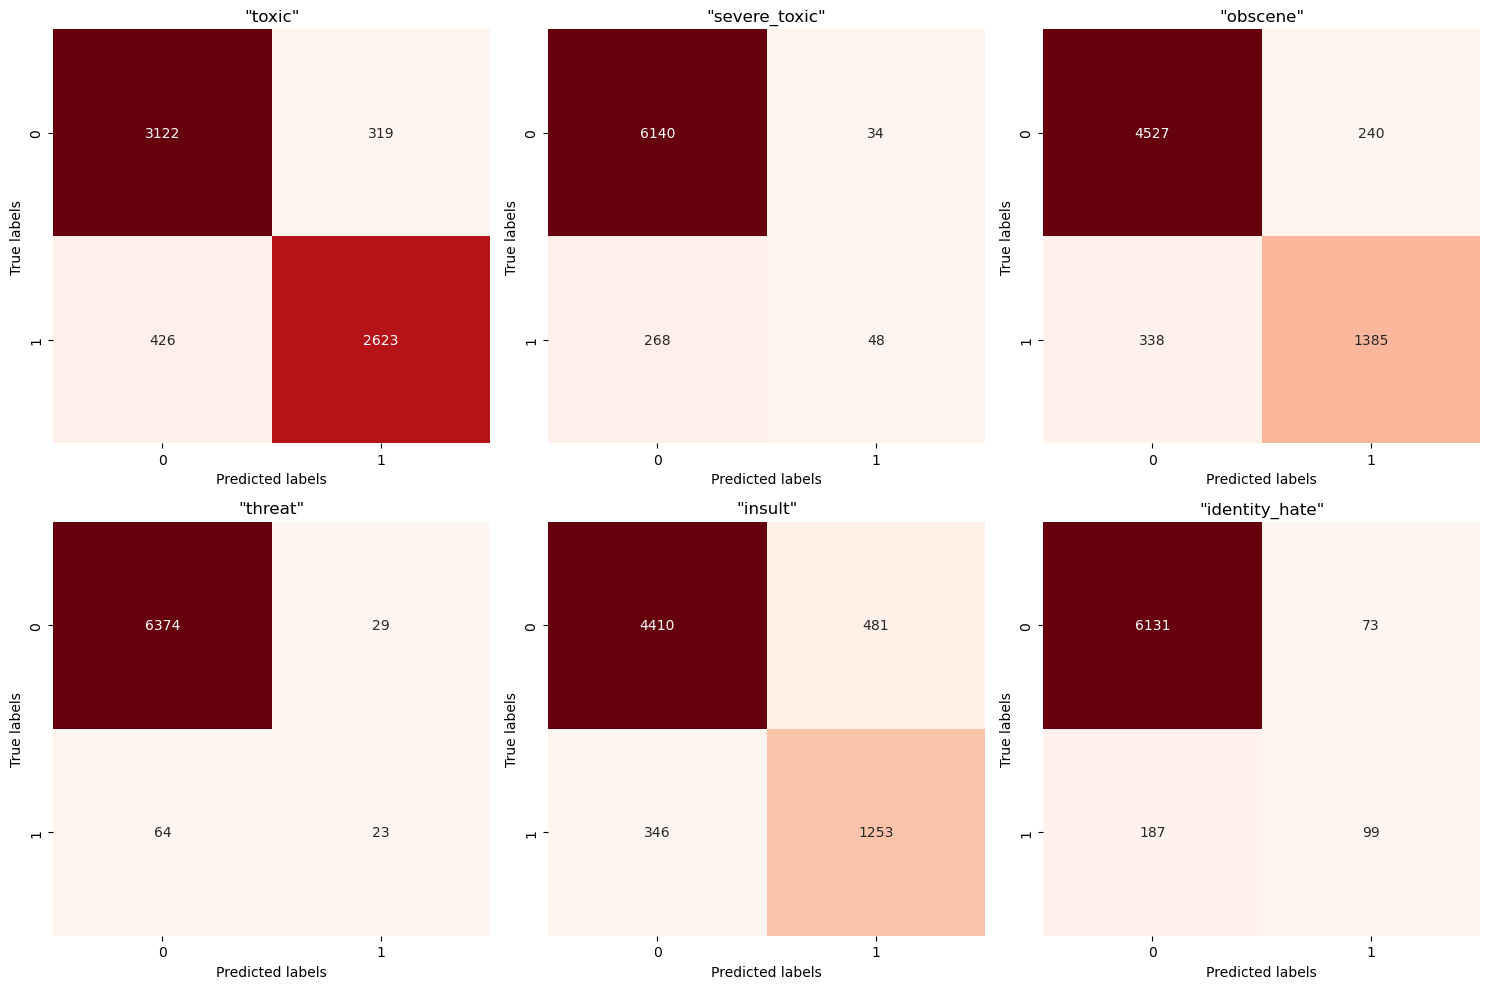

In [25]:
print_multi_conf_matrix(Y_pred_gru)

# stesso modello con word embedding di GloVe 
necessita il file: "glove.6B.100d.txt"

In [26]:
# Caricamento dei word embeddings di GloVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Preparazione della matrice di embedding
embedding_matrix = np.zeros((vocabulary_size, 100))  # sto usando GloVe con 100 dimensioni
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [27]:
clear_session()

# Inizializzazione del modello
glove_model = Sequential()
# Aggiunta del layer di embedding
glove_model.add(Embedding(vocabulary_size, 100, embeddings_initializer=Constant(embedding_matrix), input_length=maxlen, trainable=False))
# Dropout spaziale per ridurre l'overfitting
glove_model.add(SpatialDropout1D(0.2))
# Aggiunta di un GRU layer
glove_model.add(GRU(128))
# 6 categorie per la classificazione multilabel
glove_model.add(Dense(6, activation='sigmoid'))  

In [32]:
glove_model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer="adam")

In [33]:
history_2 = glove_model.fit(X_train, Y_train, validation_split=0.1, epochs=10, callbacks=[early_stopping])

Epoch 1/10
731/731 [==============================] - 882s 1s/step - loss: 0.2304 - accuracy: 0.9569 - val_loss: 0.1869 - val_accuracy: 0.9499
Epoch 2/10
731/731 [==============================] - 866s 1s/step - loss: 0.1902 - accuracy: 0.9478 - val_loss: 0.1771 - val_accuracy: 0.9368
Epoch 3/10
731/731 [==============================] - 870s 1s/step - loss: 0.1778 - accuracy: 0.9411 - val_loss: 0.1695 - val_accuracy: 0.9407
Epoch 4/10
731/731 [==============================] - 875s 1s/step - loss: 0.1706 - accuracy: 0.9404 - val_loss: 0.1673 - val_accuracy: 0.9361
Epoch 5/10
731/731 [==============================] - 871s 1s/step - loss: 0.1649 - accuracy: 0.9388 - val_loss: 0.1669 - val_accuracy: 0.9441
Epoch 6/10
731/731 [==============================] - 874s 1s/step - loss: 0.1599 - accuracy: 0.9318 - val_loss: 0.1647 - val_accuracy: 0.9391
Epoch 7/10
731/731 [==============================] - 870s 1s/step - loss: 0.1551 - accuracy: 0.9294 - val_loss: 0.1637 - val_accuracy: 0.9291

In [34]:
#salva pesi
glove_model.save_weights('GLOVE_model_weights')

In [28]:
#carica pesi
#glove_model.load_weights('GLOVE_model_weights')

In [29]:
Y_pred_glove = glove_model.predict(X_test, verbose=0)

# Conversione delle previsioni in etichette binarie
Y_pred_bin_glove = np.where(Y_pred_glove > 0.5, 1, 0)

print(classification_report(Y_test, Y_pred_bin_glove, target_names=['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']))

               precision    recall  f1-score   support

        toxic       0.85      0.93      0.89      3049
 severe_toxic       0.54      0.35      0.43       316
      obscene       0.84      0.82      0.83      1723
       threat       0.50      0.38      0.43        87
       insult       0.76      0.72      0.74      1599
identity_hate       0.57      0.42      0.48       286

    micro avg       0.80      0.80      0.80      7060
    macro avg       0.67      0.60      0.63      7060
 weighted avg       0.79      0.80      0.80      7060
  samples avg       0.40      0.40      0.39      7060



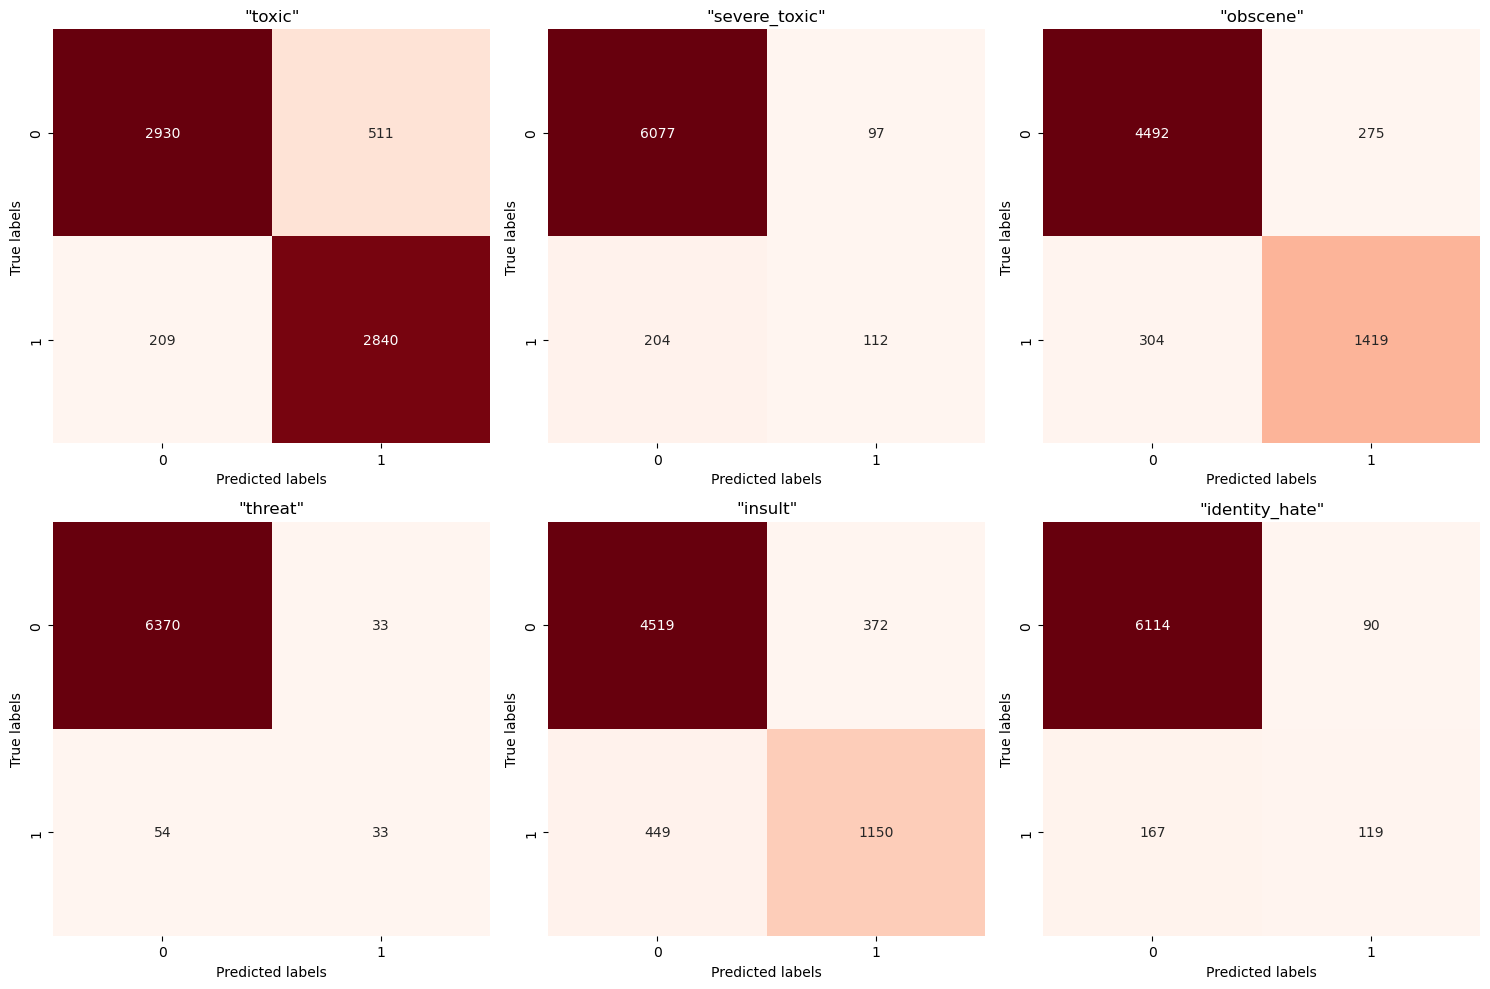

In [30]:
print_multi_conf_matrix(Y_pred_glove)

# comparazione modelli

## Prova con esempi random

In [31]:
# Lista di commenti da testare
random_comments = [
    "Such a wonderful day",
    "I hate you asshole!",
    "I don't know the answer, maybe ask someone else",
    "I kill you bastard!",
    "You fatty bastard, I don't care what you think about",
    "I will kill all niggers!!!",
    "You stupid gay deformed, nobody loves you!",
    "Suck my dick you stupid pussy!",
    "I love your contents, thank you",
    "No, enough with these shitty theories, I'm gonna burn your house with you little tacohead inside!"
]

In [32]:
def predict_toxicity(sentences, model, tokenizer, maxlen=100):
    # Nomi delle categorie
    target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    predictions = {}

    for sentence in sentences:
        # Tokenizzazione e conversione in sequenza
        sequence = tokenizer.texts_to_sequences([sentence])

        # Padding della sequenza
        sequence_padded = pad_sequences(sequence, maxlen=maxlen)

        # Predizione del modello
        prediction = model.predict(sequence_padded, verbose=0)

        # Conversione della previsione in etichette binarie
        prediction_bin = np.where(prediction > 0.5, 1, 0)

        # Mappatura delle previsioni con i nomi delle categorie
        predictions_with_names = {target_names[i]: prediction_bin[0][i] for i in range(len(target_names))}

        # Aggiunta delle previsioni al dizionario
        predictions[sentence] = predictions_with_names

    return predictions


In [33]:
def compare_predictions(sentences, model1, model2, model1_name, model2_name, tokenizer):
    # Previsioni dei due modelli
    predictions1 = predict_toxicity(sentences, model1, tokenizer)
    predictions2 = predict_toxicity(sentences, model2, tokenizer)

    # Confronto delle previsioni
    for sentence in sentences:
        print(f"Predictions for '{sentence}':")

        print(f"\n{model1_name}:")
        toxic_categories1 = [category for category, prediction in predictions1[sentence].items() if prediction == 1]
        if toxic_categories1:
            for category in toxic_categories1:
                print(category)
        else:
            print("clean")
        
        print(f"\n{model2_name}:")
        toxic_categories2 = [category for category, prediction in predictions2[sentence].items() if prediction == 1]
        if toxic_categories2:
            for category in toxic_categories2:
                print(category)
        else:
            print("clean")

        print("\n")
        print("-----------------------------------------------------")

In [34]:
compare_predictions(random_comments, gru_model, glove_model, "GRU from zero","GRU with GloVe",tokenizer)

Predictions for 'Such a wonderful day':

GRU from zero:
clean

GRU with GloVe:
clean


-----------------------------------------------------
Predictions for 'I hate you asshole!':

GRU from zero:
toxic
obscene
insult

GRU with GloVe:
toxic
obscene
insult


-----------------------------------------------------
Predictions for 'I don't know the answer, maybe ask someone else':

GRU from zero:
clean

GRU with GloVe:
clean


-----------------------------------------------------
Predictions for 'I kill you bastard!':

GRU from zero:
toxic
obscene
threat
insult

GRU with GloVe:
toxic
obscene
threat
insult


-----------------------------------------------------
Predictions for 'You fatty bastard, I don't care what you think about':

GRU from zero:
toxic
obscene
insult

GRU with GloVe:
toxic
obscene
insult


-----------------------------------------------------
Predictions for 'I will kill all niggers!!!':

GRU from zero:
toxic
threat
identity_hate

GRU with GloVe:
toxic
obscene
threat
insult


## ROC-AUC Curve

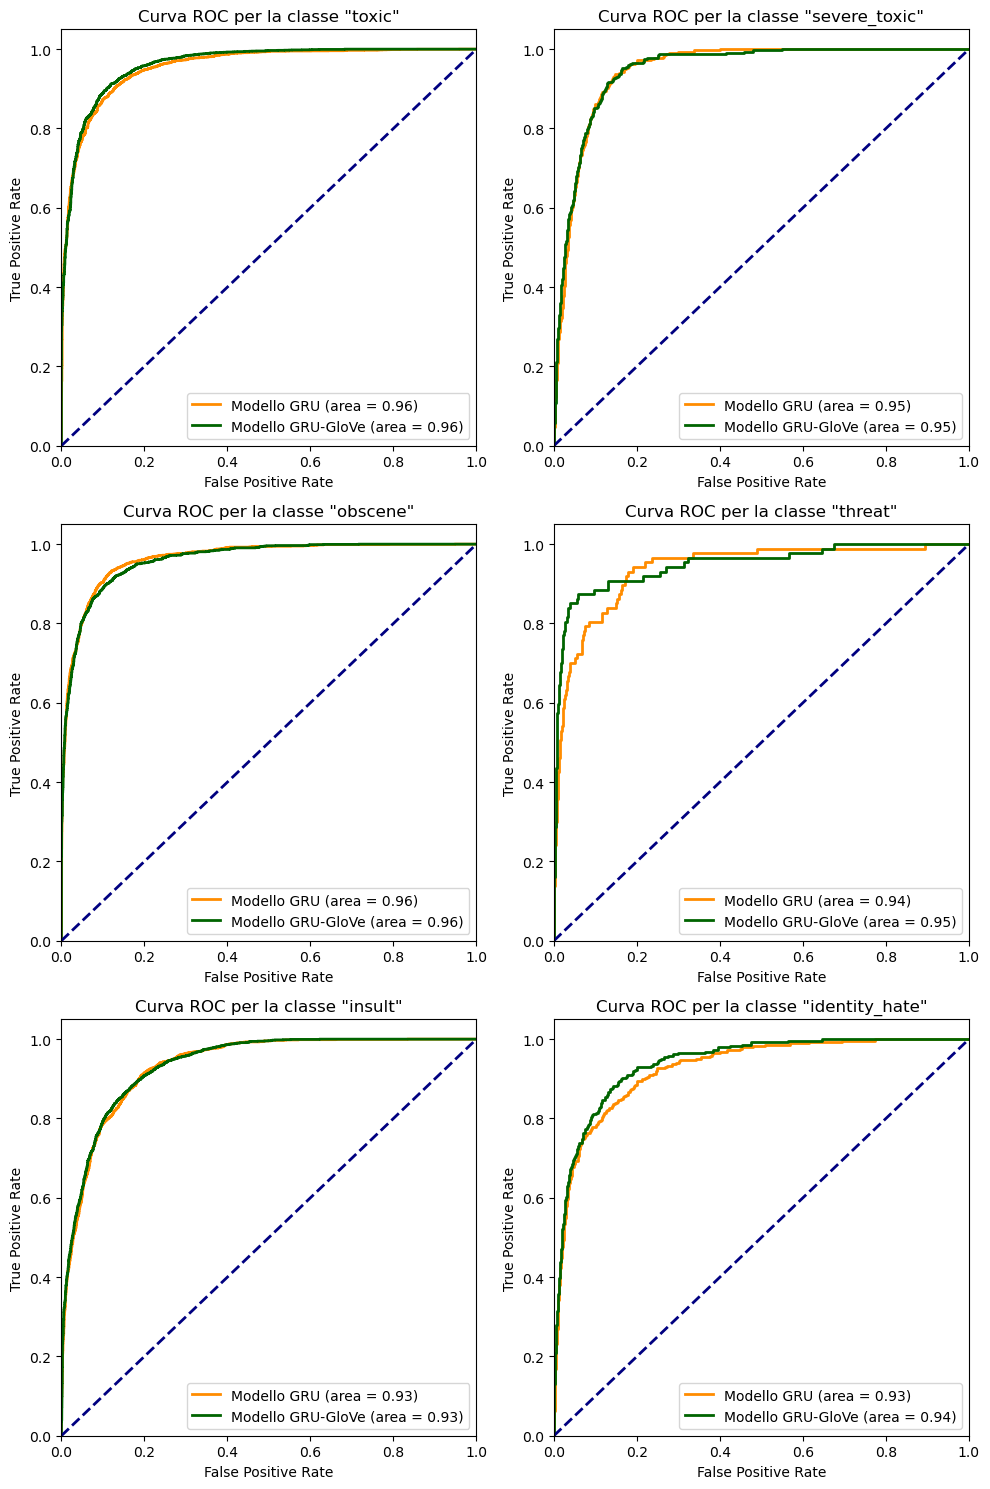

In [35]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


# Binarizza le etichette in un formato one-vs-all per il calcolo della ROC
y_test_bin = label_binarize(Y_test, classes=[0, 1, 2, 3, 4, 5])

target_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calcolo della curva ROC e dell'AUC per ogni classe
fig, axs = plt.subplots(3, 2, figsize = (10,15))
for i in range(6):
    fpr1, tpr1, _ = roc_curve(y_test_bin[:, i], Y_pred_gru[:, i])
    roc_auc_gru = auc(fpr1, tpr1)
    fpr2, tpr2, _ = roc_curve(y_test_bin[:, i], Y_pred_glove[:, i])
    roc_auc_glove = auc(fpr2, tpr2)

    # Creazione del grafico
    ax = axs[i // 2, i % 2]
    lw = 2
    ax.plot(fpr1, tpr1, color='darkorange', lw=lw, label='Modello GRU (area = %0.2f)' % roc_auc_gru)
    ax.plot(fpr2, tpr2, color='darkgreen', lw=lw, label='Modello GRU-GloVe (area = %0.2f)' % roc_auc_glove)
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Curva ROC per la classe "{}"'.format(target_names[i]))
    ax.legend()

plt.tight_layout()
plt.show()


# Analisi errori: qualche commento pulito è stato classificato come tossico?

In [36]:
def print_misclassified_comments(df_test, Y_test, Y_pred_bin, model_name):
    # Trova gli indici dei commenti sani che sono stati erroneamente classificati come tossici
    fp_indices = np.where((Y_test.sum(axis=1) == 0) & (Y_pred_bin.sum(axis=1) > 0))[0]

    # Stampa alcuni esempi di commenti sani erroneamente classificati come tossici
    print(f"Esempi di commenti sani erroneamente classificati come tossici dal modello {model_name}:")
    print("\n")
    for i in fp_indices[:10]:
        print(f"Commento: {df_test[i]}")
        print(f"Label predetti: {np.array(categories)[Y_pred_bin[i] == 1]}")
    print("----------------------------------------------------------------------------------")


In [37]:
#categorie
categories = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [38]:
# Modello Gru
print_misclassified_comments(df_test, Y_test, Y_pred_bin_gru, "GRU")

Esempi di commenti sani erroneamente classificati come tossici dal modello GRU:


Commento: "
Thanks for picking up the silly errors. Ponting only has two siblings, while he was 14 when he hurt his arm. Interesting that it was his right arm.... ''''  (talk'')  Review me! "
Label predetti: ['toxic' 'obscene' 'insult']
Commento: YOUR PSYCHOLOGICAL PROBLEMS: SOME ADVICE

Dude, I am looking over your extensive edit history, and I want to share some guidance that no one else may have the guts or, more likely, care enough to do.  You are quite obviously a very, very, very sick person.  I can't even begin to imagine the scene: you sitting in your closet of a house editing this site all day with intensity and your eyes glued, looking for the next battle and declaring these little wars over nothingness.  What posseses you to waste your life this way?  Do you get laid?  Do you need further explanations as to why you are wasting oxygen and DNA with your efforts?  Do you have anyone who knows you 

In [39]:
#Gru-GloVe
print_misclassified_comments(df_test, Y_test, Y_pred_bin_glove, "GRU-GloVe")

Esempi di commenti sani erroneamente classificati come tossici dal modello GRU-GloVe:


Commento: YOUR PSYCHOLOGICAL PROBLEMS: SOME ADVICE

Dude, I am looking over your extensive edit history, and I want to share some guidance that no one else may have the guts or, more likely, care enough to do.  You are quite obviously a very, very, very sick person.  I can't even begin to imagine the scene: you sitting in your closet of a house editing this site all day with intensity and your eyes glued, looking for the next battle and declaring these little wars over nothingness.  What posseses you to waste your life this way?  Do you get laid?  Do you need further explanations as to why you are wasting oxygen and DNA with your efforts?  Do you have anyone who knows you waste your life like this?  Please don't be offended.  But please just stop.  You have a very serious illness.  See a psychologist but, for God's sake, peel yourself away from this web site and do something with your life before it

## con quali etichette il modello misclassifica i commenti sani?

In [40]:
def count_misclassified_comments(Y_test, Y_pred_bin, model_name):
    # Trova gli indici dei commenti sani che sono stati erroneamente classificati come tossici
    fp_indices = np.where((Y_test.sum(axis=1) == 0) & (Y_pred_bin.sum(axis=1) > 0))[0]

    # Conta il numero di commenti sani erroneamente classificati in ciascuna categoria
    misclassified_counts = np.sum(Y_pred_bin[fp_indices], axis=0)

    # Stampa il numero di commenti sani erroneamente classificati in ciascuna categoria
    print(f"Numero di commenti sani erroneamente classificati in ciascuna categoria dal modello {model_name}:")
    for category, count in zip(categories, misclassified_counts):
        print(f"{category}: {count}")
    print("----------------------------------------------------------------------------------")

# Chiamata della funzione per entrambi i modelli
count_misclassified_comments(Y_test, Y_pred_bin_gru, "GRU")
count_misclassified_comments(Y_test, Y_pred_bin_glove, "GRU-GloVe")


Numero di commenti sani erroneamente classificati in ciascuna categoria dal modello GRU:
toxic: 188
severe_toxic: 1
obscene: 11
threat: 3
insult: 12
identity_hate: 6
----------------------------------------------------------------------------------
Numero di commenti sani erroneamente classificati in ciascuna categoria dal modello GRU-GloVe:
toxic: 345
severe_toxic: 1
obscene: 18
threat: 2
insult: 12
identity_hate: 7
----------------------------------------------------------------------------------


## numero totale di commenti sani classificati come tossici dai due modelli

In [42]:

def count_total_misclassified_comments(Y_test, Y_pred_bin, model_name):
    # Trova gli indici dei commenti sani che sono stati erroneamente classificati come tossici
    fp_indices = np.where((Y_test.sum(axis=1) == 0) & (Y_pred_bin.sum(axis=1) > 0))[0]

    # Stampa il numero totale di commenti sani erroneamente classificati come tossici
    print(f"Numero totale di commenti sani erroneamente classificati come tossici dal modello {model_name}: {len(fp_indices)}")

# Chiamata della funzione per entrambi i modelli
count_total_misclassified_comments(Y_test, Y_pred_bin_gru, "GRU")
count_total_misclassified_comments(Y_test, Y_pred_bin_glove, "GRU-GloVe")


Numero totale di commenti sani erroneamente classificati come tossici dal modello GRU: 190
Numero totale di commenti sani erroneamente classificati come tossici dal modello GRU-GloVe: 345


# Conclusioni

- **Considerando le metriche il migliore sembra essere il modello GRU con lo strato di word embedding di GloVe, che si comporta meglio nelle categorie meno rappresentate dal dataset**

- **da notare però che il modello GRU-Glove misclassifica di più i commenti sani come tossici, ciò probabilmente denota una troppa sensibilità ad alcune parole inoffensive che il modello non reputa tali**

- **Personalmente io ritengo più importante evitare di classificare come tossico un commento sano, evitando così di bannare un eventuale utente senza un'effettiva ragione, quindi al momento ritengo il primo modello più pronto ad essere utilizzato, nonostante le performance inferiori, ciò non toglie che un'ottimizzazione più profonda possa portare il secondo modello ad essere preferibile**